# Variational Monte Carlo


In [100]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import operator

from scipy.linalg import eigh_tridiagonal
from copy import deepcopy

from numba import njit
import time 
import random
import itertools
import sys
from copy import deepcopy
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from matplotlib import cm

import seaborn as sns; 

### Distance Matrix for initialization 

In [84]:
def nextElementOf(k ,L):
    """
        Computes the index of the next spin when a current index is given.
        
        Parameters
        ----------
        k : int
            index of the current spin 
        L : int
            Number of spins in 1d lattice
            
        Returns
        -------
        (k+1)%L : index of the next spin
        """
    # with PBC conditions
    return (k+1)%L

In [85]:
#Let's use the convention of up is +1 and -1 is down for the moment
# Only applicable when h_field=0
def get_init_x(nn):
    """
        Initial spin configuration considered as alternating up, down, up, down,......
        Parameters
        ----------
        nn : int
            Number of spins in 1d lattice 
        h : float
            External field acting on the spins
            
        Returns
        -------
        x : list/vector of dimension nn, with elements +1,-1,+1,-1.... when h!=0
        """
    
    x = np.ones((nn))
    x[1::2] = -1
    return x

In [86]:
def compute_distance_matrix(nn):
    """
        Computes spin jastrow factor v_ij = ln((d_ij)^2) depends parametrically on the cord-distance d_ij
        between 2 sites given by d_ij = 2*sin(pi*abs(i-j)/L).  
        
        Parameters
        ----------
        nn : int
            Number of spins in 1d lattice 
            
        Returns
        -------
        distance_matrix : matrix of dimension nn x nn
        """
    
    distance_matrix = np.zeros((nn,nn))
    for ii in range(1, nn):
        for jj in range(ii):
            distance_matrix[ii, jj] = 2.0*np.log(abs(np.sin(np.pi*abs(float(ii-jj))/nn)))
            
    return distance_matrix 

def compute_matrix_products_spins(vec):
    """
        Computes the products of spins.
        Parameters
        ----------
        vec : numpy 1D array with elements being +1 or -1
              Single configuration of spins 
            
        Returns
        -------
        matrix_products_spins : matrix of dimension nn x nn, whose elements are simply products of S_i and S_j
        """

    nn = len(vec)
    matrix_products_spins = np.zeros((nn,nn))
    for ii in range(1, nn):
        for jj in range(ii):
            matrix_products_spins[ii,jj] = vec[ii]*vec[jj]
    
    return matrix_products_spins

In [87]:
def wfRatio( x, k, alpha, v, sMatrix, h, updateS = False):
    """
        Computes the wave function ratio where wf is given by signM(x) * exp( 0.5*alpha *summ(v_ij*2S_i*2S_j)).
        This function calculates the ratio ψ(x')/ψ(x), where x' is the configuration obtained from x
        by flipping spin k and spin k+1.

        Parameters
        ----------
        x : list/vector of dimension nn, with elements being +1 or -1.
        k : int
            index of the current spin 
        alpha : float
            Variational parameter
        v  : numpy 2D array, float
            Spin Jastrow factor computed from defn compute_distance_matrix(nn)
        sMatrix  : matrix of dimension nn x nn, whose elements are simply products of S_i and S_j
        h  : float
            external magnetic field
        updateS : bool
            sMatrix gets updated when True.
            
        Returns
        -------
        signM_ratio*np.exp(alpha*2.0*expSum) : float
                                              ratio of wf with new configuration and old configuration
        sMatrix : numpy 2D array, int
                  updated spin-spin product matrix  
        """

    L = len(x)
    kNext = nextElementOf(k, L)
    #   Set the ratio of the M signs << "Energy (per site) = " 
    signM_ratio = -1
    #    Do the (half) sums in the ratio of the exponentials 
    expSum = 0.0

    #     i = k 
    for j in range(k):
        if j != kNext:            
            expSum += -v[k,j]*sMatrix[k,j]

    #     i = kNext 
    for j in range(kNext):
        if j != k:            
            expSum += -v[kNext,j]*sMatrix[kNext,j]


    #    j = k 
    for i in range(k+1, L):
        if i != kNext:
            expSum += -v[i,k]*sMatrix[i,k]

    #    j = kNext 
    for i in range(kNext+1, L):
        if i != k:
             expSum += -v[i,kNext]*sMatrix[i,kNext]


    #  Update sMatrix if required 
    if updateS == True:
        #  i = k 
        for j in range(k):
            if j != kNext:
                sMatrix[k,j] *= -1

        for j in range(kNext):
            if j != k:
                sMatrix[kNext,j] *= -1

        # j = k 
        for i in range( k+1, L):
            if i != kNext:
                sMatrix[i,k] *= -1

        # j = kNext
        for i in range(kNext+1, L):
            if i != k:
                sMatrix[i,kNext] *= -1

    return signM_ratio*np.exp(alpha*2.0*expSum), sMatrix

In [94]:
def localEnergy(x, alpha, v, sMatrix, h):
    """
        This function calculates the local energy.
        The calculation is achieved by first getting the
          contributions from x'!=x, and then x'=x.

        Parameters
        ----------
        x : list/vector of dimension nn, with elements being +1 or -1.
        alpha : float
            Variational parameter
        v  : numpy 2D array, float
            Spin Jastrow factor computed from defn compute_distance_matrix(nn)
        sMatrix  : matrix of dimension nn x nn, whose elements are simply products of S_i and S_j
        h  : float
            external magnetic field
            
        Returns
        -------
        elocal : float
                 local energy
        """
    #    Initialize the required variables
    eLocal = 0.0
    eBuffer = 0.0
    L = len(x)
    kNext = 0
        
    # Add the contribution from x'!=x and calculate nPairs 
    for k in range(L):
        kNext = nextElementOf(k, L);
        if x[k] != x[kNext]: 
            eBuffer, sMatrix = wfRatio( x, k, alpha, v, sMatrix, False)
            eLocal += eBuffer

    eLocal = 0.5*eLocal

    #adding contribution x'==x
    for k in range(L):
            eLocal += 0.5*0.5*x[k]*x[nextElementOf(k, L)]
    return eLocal


In [91]:
def fix_Sz(nn, count):
    """
    This function returns a random initial configuration with "counts" numbers of -1
    
    Parameters
    ----------
    nn = int
         Number of spins in 1D lattice   
    count = int
         Number of spins dowsn 
    """
    nums = np.ones(nn,dtype=int)
    nums[:count] = -1
    np.random.shuffle(nums)
    return nums

In [93]:
def main( L = 10, LenSim = 1000000,  h=0 , alpha_min  =0.15, alpha_max = 0.405, alpha_step = 0.01, place_one=1):
    """
        This function begins the Variational Monte carlo Simulation. 

        Parameters
        ----------
        L  : int
            Number of spins in 1D lattice
        LenSim : int
            Number of iterations for Monte carlo
        h  : float
            external magnetic field
        alpha_min, alpha_max, alpha_step  : float
             range of parameter values   
        place_one  : int (shouldn't be greater than L+1)     
             number of 1's to be placed in list of -1's of size L.
             
        Returns
        -------

        alphaRange : list of float
            range of parameter values 
        E: list of float
           ground state energy values for different values of parameter alpha
        ((cpu1 - cpu0)/60) : list of float
            CPU time taken to execute the full simulation
            
        xInit: Numpy array
              initial configuration |x>
        
        """

    
    #Timer
    cpu0 = time.time()
    
    #Sys simulation param
    alphaRange = np.arange(alpha_min, alpha_max, alpha_step)
    
    #+ initialization
    xInit = np.zeros((L))
    v = np.zeros((L, L))
    sMatrixInit = np.zeros((L, L))
    ELocal = 0.0
    
    #Initialize the file variables
    alpha_list = []
    Elocal_list = []
 
    
    #Initialize first values
    # x initialized to up-down-up-down..
    xInit = fix_Sz(L, place_one )
    # v is basically the distance matrix
    v = compute_distance_matrix(L)
    
    #Just the matrix of the products of the spins of x 
    sMatrixInit = compute_matrix_products_spins(xInit)
     
    #Do the variational Loop
    #Here we loop on the variational parameter alpha
    
    E = []
    for alphaIdx in range(len(alphaRange)):
        # Assign alpha;
        alpha = alphaRange[alphaIdx]
        
        #Make a local copy of the initial x and sMatrix 
        x = deepcopy(xInit)
        sMatrix = deepcopy(sMatrixInit)
        
        #Calculate the local energy for the first time
        ElocalCumulative = 0.0
        ELocal = localEnergy(x, alpha, v, sMatrix,  h)
        ElocalCumulative += ELocal
        
        
        #Write on file the first configuration
        alpha_list.append(alpha)
        Elocal_list.append(ELocal/L)
        
        #Begin MAIN MC Loop
        # Initialize Metropolis variables
        k = 0
        kNext = 0
        mRatio = 0
        sNew = np.zeros((L, L))
        acc = 0
        
        #print('Cycle progress=')
        for cycle in range(LenSim):
            #Select a new move (i.e. flip k and k+1) 
        
            k = round(random.random()*(L-1))
            kNext = nextElementOf(k, L)
            
            # Do Metropolis only if we flip different spins,
            # because of the constraint on the total spin
            
            if (x[kNext] != x[k]):
                sNew = deepcopy(sMatrix)
                mRatio, sNew = wfRatio(x, k, alpha, v, sNew,h,  True)
                mRatio = pow(mRatio, 2.0)
                
               #if ( (mRatio < 1) ? (ran1(&idum) < mRatio) : 1 )
               
                r = np.random.rand()
                
                if ((r<mRatio and mRatio<1) or (mRatio>1)):                    
                    acc +=1
                    # Update x by ASSUMING we flip two different spins.
                    # The assumption holds because of the "if" that skips
                    # this section if we flip two equal spins.

                    x[k] = -deepcopy(x[k])
                    x[kNext] = -deepcopy(x[kNext])

                    #Update the sMatrix
                    sMatrix = deepcopy(sNew)

                    # Calculate the local energy
                    ELocal = localEnergy(x, alpha, v, sMatrix, h)

            #Update the cumulant of the local energy
            ElocalCumulative += ELocal
            
        E.append(ElocalCumulative/(LenSim*L))
    cpu1 = time.time()
    #print('N = %d, h = %.2f, time = %f minutes' %(L,h, (cpu1 - cpu0)/60))
    return E, alphaRange, xInit, ((cpu1 - cpu0)/60) 

In [12]:
# Testing for a specific case..........
m_values = []
E_vs_m   = []

nn       = 8
h_field  = 0.
print("##########################")
print("L = ", nn, "h = ", h_field)
print("##########################")
for i in range(nn+1):
    E, F_m, alpha, xInit, t = main(L=nn,LenSim=10000, h=h_field, place_one=i)
    E_min = min(E)
    magn  = 0.5*np.mean(xInit)
    m_values.append(magn)
    E_vs_m.append(E_min)
    optE_alpha = alpha[np.argmin(E)]
    print("Config: ", xInit, "    Sz: ", sum(xInit), "     m: ", magn )
    print("E_min = ", round(E_min,5), "    OptE_alpha:", optE_alpha)

##########################
L =  8 h =  0.0
##########################
Config:  [-1, -1, -1, -1, -1, -1, -1, -1]     Sz:  -8      m:  -0.5
E_min =  0.25002     OptE_alpha: 0.15
Config:  [1, -1, -1, -1, -1, -1, -1, -1]     Sz:  -6      m:  -0.375
E_min =  -0.0     OptE_alpha: 0.40000000000000024
Config:  [-1, -1, 1, -1, -1, -1, 1, -1]     Sz:  -4      m:  -0.25
E_min =  -0.22517     OptE_alpha: 0.19000000000000003
Config:  [-1, -1, -1, -1, 1, 1, -1, 1]     Sz:  -2      m:  -0.125
E_min =  -0.3912     OptE_alpha: 0.23000000000000007
Config:  [-1, 1, -1, 1, -1, 1, -1, 1]     Sz:  0      m:  0.0
E_min =  -0.45652     OptE_alpha: 0.24000000000000007
Config:  [-1, 1, 1, -1, -1, 1, 1, 1]     Sz:  2      m:  0.125
E_min =  -0.39093     OptE_alpha: 0.22000000000000006
Config:  [1, -1, 1, 1, 1, 1, -1, 1]     Sz:  4      m:  0.25
E_min =  -0.2252     OptE_alpha: 0.18000000000000002
Config:  [1, 1, 1, 1, 1, 1, 1, -1]     Sz:  6      m:  0.375
E_min =  -0.0     OptE_alpha: 0.40000000000000024
Config

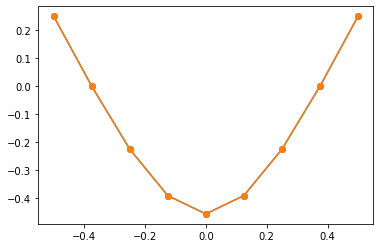

-0.45651769327457314

In [13]:
def get_energy_with_field(energies, magnetizations, h_field):
    """
        This function computes F(m) = E(m) - h*m where m = 0.5*sum(all_spins)/(number of spins)
        
        Parameters
        ----------
        energies : float
              np array of all the min energies found for different Initial configurations
        magnetizations : float
              np array of all the m values found for different Initial configurations
        h_field  : float
               value of external magnetic field 
        
        Returns
        -------
        final_energies  :  float
            np array given by the formula in the description.
        """
    
    en_arr = np.array(energies)
    
    final_energies = np.array([energy - magn*h_field for energy, magn in zip(en_arr, magnetizations)])
    
    return final_energies

energies_ok = get_energy_with_field(E_vs_m, m_values, 0)
plt.plot(m_values, E_vs_m, '-o')
plt.plot(m_values, energies_ok, '-o')
plt.show()
min(energies_ok)

In [96]:
# Store all the info the values of E0 for different h_field and even values of nn
nn_part = np.array([2,4,6,8,10,12])
list_dic = []
final_time = []
h_field  = 0.
for nn in nn_part:
    start = time.time()
    m_values = []
    E_vs_m   = []
    alpha_list = []
    xInit_list = []
    t_list = []
    print("##########################")
    print("L = ", nn, "h = ", h_field)
    print("##########################")
    for i in range(nn+1):
        #Computing the Energies for the different Sz
        E,alpha, xInit, t = main(L=nn,LenSim=100000, h=h_field, place_one=i)
        
        #Computing the minimum E obtained for the best optimal alpha
        E_min = min(E)
        optE_alpha = alpha[np.argmin(E)]
        
        #Computing magnetization
        magn  = 0.5*np.mean(xInit)
        
        #saving values
        m_values.append(magn)
        E_vs_m.append(E_min)
        t_list.append(t)
        
        # create a list of optimal alphas where E is min.
        alpha_list.append(optE_alpha)
        xInit_list.append(xInit)
        
    for h_val in np.arange(0, 3.05, 0.05):
        energies_ok = get_energy_with_field(E_vs_m, m_values, h_val)

        list_dic.append({"nn": nn, "h_field": h_val, "energy": min(energies_ok),
                        "optimal_alpha":alpha_list[np.argmin(energies_ok)], 
                         "Init_config":str(xInit_list[np.argmin(energies_ok)]),"cpu_time(min)":t_list[np.argmin(energies_ok)]})
        
        print("nn:", nn, "h_field:", h_val, "energy:", min(energies_ok),
                        "optimal_alpha:",alpha_list[np.argmin(energies_ok)], 
                         "Init_config:",str(xInit_list[np.argmin(energies_ok)]),"cpu_time(min)",t_list[np.argmin(energies_ok)]) 
    print("")
    end = time.time()
    time_final = (end-start)/60
    final_time.append(time_final)

##########################
L =  2 h =  0.0
##########################
nn: 2 h_field: 0.0 energy: -0.7500075 optimal_alpha: 0.15 Init_config: [ 1 -1] cpu_time(min) 0.4383062799771627
nn: 2 h_field: 0.05 energy: -0.7500075 optimal_alpha: 0.15 Init_config: [ 1 -1] cpu_time(min) 0.4383062799771627
nn: 2 h_field: 0.1 energy: -0.7500075 optimal_alpha: 0.15 Init_config: [ 1 -1] cpu_time(min) 0.4383062799771627
nn: 2 h_field: 0.15000000000000002 energy: -0.7500075 optimal_alpha: 0.15 Init_config: [ 1 -1] cpu_time(min) 0.4383062799771627
nn: 2 h_field: 0.2 energy: -0.7500075 optimal_alpha: 0.15 Init_config: [ 1 -1] cpu_time(min) 0.4383062799771627
nn: 2 h_field: 0.25 energy: -0.7500075 optimal_alpha: 0.15 Init_config: [ 1 -1] cpu_time(min) 0.4383062799771627
nn: 2 h_field: 0.30000000000000004 energy: -0.7500075 optimal_alpha: 0.15 Init_config: [ 1 -1] cpu_time(min) 0.4383062799771627
nn: 2 h_field: 0.35000000000000003 energy: -0.7500075 optimal_alpha: 0.15 Init_config: [ 1 -1] cpu_time(min) 0.4

nn: 4 h_field: 1.1500000000000001 energy: -0.5375025 optimal_alpha: 0.15 Init_config: [-1  1  1  1] cpu_time(min) 0.7094078103701273
nn: 4 h_field: 1.2000000000000002 energy: -0.5500025000000001 optimal_alpha: 0.15 Init_config: [-1  1  1  1] cpu_time(min) 0.7094078103701273
nn: 4 h_field: 1.25 energy: -0.5625025 optimal_alpha: 0.15 Init_config: [-1  1  1  1] cpu_time(min) 0.7094078103701273
nn: 4 h_field: 1.3 energy: -0.5750025000000001 optimal_alpha: 0.15 Init_config: [-1  1  1  1] cpu_time(min) 0.7094078103701273
nn: 4 h_field: 1.35 energy: -0.5875025 optimal_alpha: 0.15 Init_config: [-1  1  1  1] cpu_time(min) 0.7094078103701273
nn: 4 h_field: 1.4000000000000001 energy: -0.6000025 optimal_alpha: 0.15 Init_config: [-1  1  1  1] cpu_time(min) 0.7094078103701273
nn: 4 h_field: 1.4500000000000002 energy: -0.6125025000000001 optimal_alpha: 0.15 Init_config: [-1  1  1  1] cpu_time(min) 0.7094078103701273
nn: 4 h_field: 1.5 energy: -0.6250025 optimal_alpha: 0.15 Init_config: [-1  1  1  1] 

nn: 6 h_field: 2.15 energy: -0.8249974999999999 optimal_alpha: 0.15 Init_config: [1 1 1 1 1 1] cpu_time(min) 0.04447078307469686
nn: 6 h_field: 2.2 energy: -0.8499975000000001 optimal_alpha: 0.15 Init_config: [1 1 1 1 1 1] cpu_time(min) 0.04447078307469686
nn: 6 h_field: 2.25 energy: -0.8749975 optimal_alpha: 0.15 Init_config: [1 1 1 1 1 1] cpu_time(min) 0.04447078307469686
nn: 6 h_field: 2.3000000000000003 energy: -0.8999975000000001 optimal_alpha: 0.15 Init_config: [1 1 1 1 1 1] cpu_time(min) 0.04447078307469686
nn: 6 h_field: 2.35 energy: -0.9249975 optimal_alpha: 0.15 Init_config: [1 1 1 1 1 1] cpu_time(min) 0.04447078307469686
nn: 6 h_field: 2.4000000000000004 energy: -0.9499975000000002 optimal_alpha: 0.15 Init_config: [1 1 1 1 1 1] cpu_time(min) 0.04447078307469686
nn: 6 h_field: 2.45 energy: -0.9749975000000001 optimal_alpha: 0.15 Init_config: [1 1 1 1 1 1] cpu_time(min) 0.04447078307469686
nn: 6 h_field: 2.5 energy: -0.9999975 optimal_alpha: 0.15 Init_config: [1 1 1 1 1 1] cpu

nn: 8 h_field: 2.5 energy: -0.9999975 optimal_alpha: 0.15 Init_config: [1 1 1 1 1 1 1 1] cpu_time(min) 0.0429810365041097
nn: 8 h_field: 2.5500000000000003 energy: -1.0249975 optimal_alpha: 0.15 Init_config: [1 1 1 1 1 1 1 1] cpu_time(min) 0.0429810365041097
nn: 8 h_field: 2.6 energy: -1.0499975 optimal_alpha: 0.15 Init_config: [1 1 1 1 1 1 1 1] cpu_time(min) 0.0429810365041097
nn: 8 h_field: 2.6500000000000004 energy: -1.0749975000000003 optimal_alpha: 0.15 Init_config: [1 1 1 1 1 1 1 1] cpu_time(min) 0.0429810365041097
nn: 8 h_field: 2.7 energy: -1.0999975000000002 optimal_alpha: 0.15 Init_config: [1 1 1 1 1 1 1 1] cpu_time(min) 0.0429810365041097
nn: 8 h_field: 2.75 energy: -1.1249975 optimal_alpha: 0.15 Init_config: [1 1 1 1 1 1 1 1] cpu_time(min) 0.0429810365041097
nn: 8 h_field: 2.8000000000000003 energy: -1.1499975 optimal_alpha: 0.15 Init_config: [1 1 1 1 1 1 1 1] cpu_time(min) 0.0429810365041097
nn: 8 h_field: 2.85 energy: -1.1749975 optimal_alpha: 0.15 Init_config: [1 1 1 1 1

nn: 12 h_field: 0.0 energy: -0.44832089591073543 optimal_alpha: 0.24000000000000007 Init_config: [-1  1  1 -1 -1  1 -1 -1 -1  1  1  1] cpu_time(min) 4.200129942099253
nn: 12 h_field: 0.05 energy: -0.44832089591073543 optimal_alpha: 0.24000000000000007 Init_config: [-1  1  1 -1 -1  1 -1 -1 -1  1  1  1] cpu_time(min) 4.200129942099253
nn: 12 h_field: 0.1 energy: -0.44832089591073543 optimal_alpha: 0.24000000000000007 Init_config: [-1  1  1 -1 -1  1 -1 -1 -1  1  1  1] cpu_time(min) 4.200129942099253
nn: 12 h_field: 0.15000000000000002 energy: -0.44832089591073543 optimal_alpha: 0.24000000000000007 Init_config: [-1  1  1 -1 -1  1 -1 -1 -1  1  1  1] cpu_time(min) 4.200129942099253
nn: 12 h_field: 0.2 energy: -0.44832089591073543 optimal_alpha: 0.24000000000000007 Init_config: [-1  1  1 -1 -1  1 -1 -1 -1  1  1  1] cpu_time(min) 4.200129942099253
nn: 12 h_field: 0.25 energy: -0.44832089591073543 optimal_alpha: 0.24000000000000007 Init_config: [-1  1  1 -1 -1  1 -1 -1 -1  1  1  1] cpu_time(min

In [97]:
#saving values
VMC_energy = pd.DataFrame(list_dic)
VMC_energy.to_csv('Variational_energy_new.csv', index = False)
VMC_energy

,nn,h_field,energy,optimal_alpha,Init_config,cpu_time(min)
0,2,0.00,-0.750008,0.15,[ 1 -1],0.438306
1,2,0.05,-0.750008,0.15,[ 1 -1],0.438306
2,2,0.10,-0.750008,0.15,[ 1 -1],0.438306
3,2,0.15,-0.750008,0.15,[ 1 -1],0.438306
4,2,0.20,-0.750008,0.15,[ 1 -1],0.438306
...,...,...,...,...,...,...
361,12,2.80,-1.149998,0.15,[1 1 1 1 1 1 1 1 1 1 1 1],0.040060
362,12,2.85,-1.174997,0.15,[1 1 1 1 1 1 1 1 1 1 1 1],0.040060
363,12,2.90,-1.199998,0.15,[1 1 1 1 1 1 1 1 1 1 1 1],0.040060
364,12,2.95,-1.224998,0.15,[1 1 1 1 1 1 1 1 1 1 1 1],0.040060


### Time complexity for computing ground state energies in $h =[0,3]$

In [ ]:
#functions to fit
def cuadratic(x, a ,b,c):
    return a*x**2 + b*x + c

R score=0.98


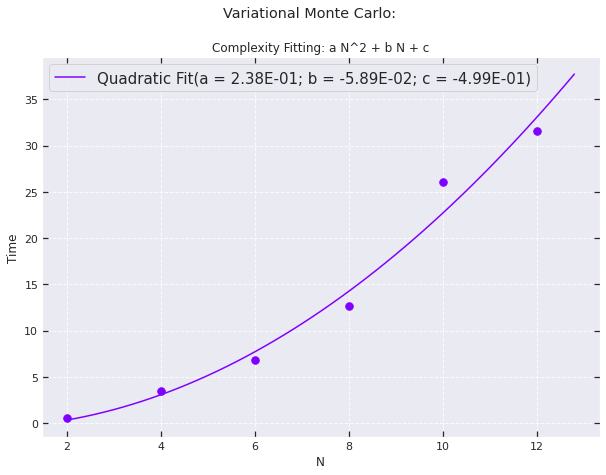

In [124]:
nn_part = np.array([2,4,6,8,10,12])

sns.set_theme(color_codes=True)
color=cm.rainbow(np.arange(0, 1, 0.15))

plt.figure(figsize=(10, 7))
plt.title('Complexity Fitting: a N^2 + b N + c')
plt.suptitle('Variational Monte Carlo: ')

i =0
plt.plot(nn_part, final_time, ".", color = color[i], markersize=15)
#cuadratic
popt_up, _   = curve_fit(cuadratic, nn_part, final_time)
nn_part_fit = np.arange(2,13,0.2)
plt.plot(nn_part_fit, cuadratic(nn_part_fit, *popt_up)
         ,color = color[i], label = 'Quadratic Fit(a = '+"{:.2E}".format(popt_up[0])
         +'; b = '+ "{:.2E}".format(popt_up[1])+'; c = '+ "{:.2E}".format(popt_up[2])+')')

print("R score="+"{:.2F}".format(r2_score( final_time,cuadratic(nn_part,*popt_up) )))

plt.ylabel('Time')
plt.xlabel('N')
plt.grid(linestyle='--',alpha=0.8,which='both')
plt.tick_params(direction='in',bottom=True,top=True,left=True,right=True)
plt.legend(loc="best",prop={'size': 15})
plt.show()

### Plotting ground state energies for several number of particles subject to an external field $h =[0,3]$

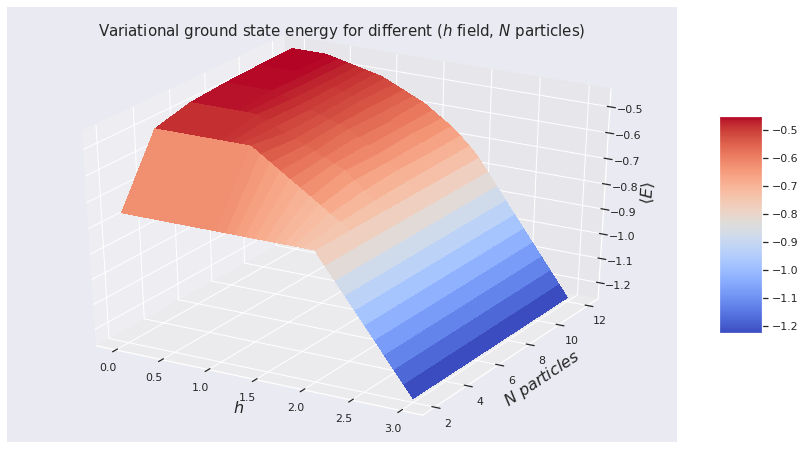

In [102]:
h_steps = np.arange(0, 3.05, 0.05)
nn      = range(2, 13, 2)

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
qutip = pd.read_csv('Qutip_energies_vs_field.csv')


Energies = np.zeros((len(nn), len(h_steps)))
for ii, n_part in enumerate(nn):
    for jj, h_field in enumerate(h_steps):
        Energies[ii, jj] = VMC_energy.energy[(VMC_energy.nn == n_part)&(VMC_energy.h_field == h_field) ]
        
# Prepare for plots
fig = plt.figure(figsize = (15,8))
ax = fig.gca(projection='3d')
# Plot the surface.
X, Y = np.meshgrid(h_steps, nn)
surf = ax.plot_surface(X, Y, Energies,cmap=cm.coolwarm,linewidth=0, antialiased=False)
# Customize the z axis.
zmin = np.matrix(Energies).min()
zmax = np.matrix(Energies).max()
ax.set_zlim(zmin, zmax)



ax.set_xlabel(r'$h$',size=16)
ax.set_ylabel(r'$N\ particles$',size=16)
ax.set_zlabel(r'$\langle E \rangle$',size=16)
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)


plt.title("Variational ground state energy for different ($h$ field, $N$ particles)",size=15)
plt.savefig('GS_VMC-3d.png')
plt.show()

In [25]:
qutip.h_field.unique()
qutip.head(20)

,nn,h_field,energy
0,2,0.00,-0.75
1,2,0.05,-0.75
2,2,0.10,-0.75
3,2,0.15,-0.75
4,2,0.20,-0.75
5,2,0.25,-0.75
6,2,0.30,-0.75
7,2,0.35,-0.75
8,2,0.40,-0.75
9,2,0.45,-0.75


### Plotting difference in ground state energies with exact values for several number of particles subject to an external field $h =[0,3]$ 

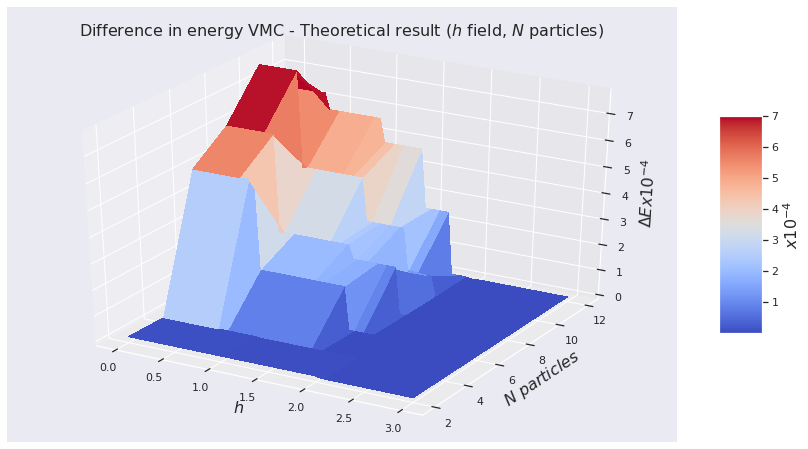

In [103]:
h_steps = np.arange(0, 3.05, 0.05)
nn      = range(2, 13, 2)


Delta_Energies = np.zeros((len(nn), len(h_steps)))

for ii, n_part in enumerate(nn):
    for jj, h_val in enumerate(qutip.h_field.unique()):
        vmc_en = Energies[ii, jj]
        Delta_Energies[ii,jj] = np.abs(vmc_en - qutip[(qutip.nn == n_part)&(qutip.h_field == h_val)].energy)
        
        
# Prepare for plots
fig = plt.figure(figsize = (15,8))
ax = fig.gca(projection='3d')
# Plot the surface.
X, Y = np.meshgrid(h_steps, nn)
surf = ax.plot_surface(X, Y, Delta_Energies*pow(10,4),cmap=cm.coolwarm,linewidth=0, antialiased=False)
# Customize the z axis.
zmin = np.matrix(Delta_Energies).min()*pow(10,4)
zmax = np.matrix(Delta_Energies).max()*pow(10,4)
ax.set_zlim(zmin, zmax)
ax.set_xlabel(r'$h$',size=16)
ax.set_ylabel(r'$N\ particles$',size=16)
ax.set_zlabel('$\\Delta E x 10^{-4}$',size=16)

cbar = fig.colorbar(surf, shrink=0.5, aspect=5)
cbar.ax.set_ylabel("$x 10^{-4}$",size=16)

plt.title("Difference in energy VMC - Theoretical result ($h$ field, $N$ particles)",size=16)
plt.savefig('Delta Energy-3d.png')
plt.show()

In [72]:
 VMC_energy[VMC_energy["h_field"]==0.00]

,nn,h_field,energy,optimal_alpha,Init_config,cpu_time(min)
0,2,0.0,-0.750008,0.15,"[1, -1]",0.385265
61,4,0.0,-0.500005,0.25,"[-1, 1, -1, 1]",0.927187
122,6,0.0,-0.466724,0.25,"[1, 1, -1, 1, -1, -1]",1.243853
183,8,0.0,-0.455695,0.25,"[1, 1, -1, -1, -1, 1, 1, -1]",1.903646
244,10,0.0,-0.450993,0.25,"[1, 1, -1, -1, 1, -1, 1, -1, -1, 1]",2.434049
305,12,0.0,-0.448319,0.24,"[-1, 1, 1, 1, 1, -1, 1, -1, -1, 1, -1, -1]",3.152824


In [ ]:
for nn in range(2,10,2):
    print("nn = ",nn, "   ", VMC_energy[VMC_energy["h_field"]=0.00]["energy"]  )

In [39]:
VMC_energy

,nn,h_field,energy,optimal_alpha,Init_config,cpu_time(min)
0,2,0.00,-0.750008,0.15,"[1, -1]",0.385265
1,2,0.05,-0.750008,0.15,"[1, -1]",0.385265
2,2,0.10,-0.750008,0.15,"[1, -1]",0.385265
3,2,0.15,-0.750008,0.15,"[1, -1]",0.385265
4,2,0.20,-0.750008,0.15,"[1, -1]",0.385265
...,...,...,...,...,...,...
361,12,2.80,-1.149998,0.15,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.034369
362,12,2.85,-1.174997,0.15,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.034369
363,12,2.90,-1.199998,0.15,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.034369
364,12,2.95,-1.224998,0.15,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.034369


### Plotting ground state energies for several number of particles subject to an external field $h =[0,3]$ in 2D

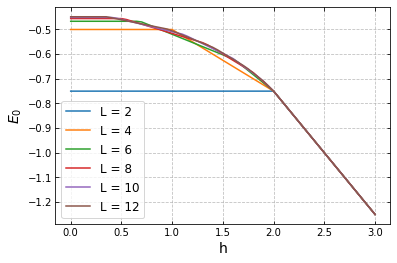

In [47]:
# E0 vs h plot
for L in [2,4,6,8,10,12]:
    h_field = np.array(VMC_energy[VMC_energy["nn"]==L]["h_field"])
    E0 = np.array(VMC_energy[VMC_energy["nn"]==L]["energy"])
    plt.plot(h_field, E0,label="L = %d"%L)

plt.legend(loc='best',prop={'size': 12})
plt.tick_params(direction='in',bottom=True,top=True,left=True,right=True)
plt.grid(linestyle='--',alpha=0.8,which='both')

plt.xlabel("h",size=14)
plt.ylabel("$E_0$",size=14)
plt.show()    

### Plotting optimal $alpha$ for several number of particles subject to an external field $h =[0,3]$ 

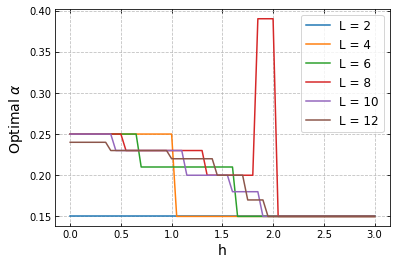

In [50]:
# E0 vs h plot
for L in [2,4,6,8,10,12]:
    h_field = np.array(VMC_energy[VMC_energy["nn"]==L]["h_field"])
    alpha = np.array(VMC_energy[VMC_energy["nn"]==L]["optimal_alpha"])
    plt.plot( h_field,alpha,label="L = %d"%L)

plt.legend(loc='best',prop={'size': 12})
plt.tick_params(direction='in',bottom=True,top=True,left=True,right=True)
plt.grid(linestyle='--',alpha=0.8,which='both')

plt.xlabel("h",size=14)
plt.ylabel("Optimal $\\alpha$",size=14)
plt.show()    

## Case h = 0

### Ground state given by the Neel state |+-+-+-+..>



In [ ]:
# modify the definition accordingly since we want only to do simulations for h=0. The previous definition of main 
# is more general where h=0 and h!=0 are both included. 

def main( L = 10, LenSim = 1000000,  h=0 , alpha_min  =0.2, alpha_max = 0.305, alpha_step = 0.01):
    """
        This function begins the Variational Monte carlo Simulation. 

        Parameters
        ----------
        L  : int
            Number of spins in 1D lattice
        LenSim : int
            Number of iterations for Monte carlo
        h  : float
            external magnetic field
        alpha_min, alpha_max, alpha_step  : float
             range of parameter values   
        
        Returns
        -------
        alphaRange : list of float
            range of parameter values 
        E: list of float
           ground state energy values for different values of parameter alpha
        ((cpu1 - cpu0)/60) : list of float
            CPU time taken to execute the full simulation
        
        """

    
    #Timer
    cpu0 = time.time()
    
    #Sys simulation param
    alphaRange = np.arange(alpha_min, alpha_max, alpha_step)
    
    #+ initialization
    xInit = np.zeros((L))
    v = np.zeros((L, L))
    sMatrixInit = np.zeros((L, L))
    ELocal = 0.0
 
    
    #Initialize the file variables
    alpha_list = []
    Elocal_list = []
    
    #Initialize first values
    # x initialized to up-down-up-down..
    xInit = get_init_x(L)
    # v is basically the distance matrix
    v = compute_distance_matrix(L)
    
    #Just the matrix of the products of the spins of x 
    sMatrixInit = compute_matrix_products_spins(xInit)

    #Do the variational Loop
    #Here we loop on the variational parameter alpha
    E = []
    
    for alphaIdx in range(len(alphaRange)):
        # Assign alpha;
        alpha = alphaRange[alphaIdx]
        #Make a local copy of the initial x and sMatrix 
        x = deepcopy(xInit)
        
        #Calculate the local energy for the first time
        ElocalCumulative = 0.0
        Elocal = localEnergy(x, alpha, v, sMatrix,  h)
        ElocalCumulative += Elocal
        
        #Write on file the first configuration
        alpha_list.append(alpha)
        Elocal_list.append(Elocal/L)
   
        
        #Begin MAIN MC Loop
        # Initialize Metropolis variables
        k = 0
        kNext = 0
        mRatio = 0
        sNew = np.zeros((L, L))
        acc = 0
        
        #print('Cycle progress=')
        for cycle in range(LenSim):
            #Select a new move (i.e. flip k and k+1) 
            k = round(np.random.randint(L-1))
            kNext = nextElementOf(k, L)
            
            #Do Metropolis only if we flip different spins,
            #because of the constraint on the total spin
            
            if (x[kNext] != x[k]):
                sNew = deepcopy(sMatrix)
                mRatio, sNew = wfRatio(x, k, alpha, v, sNew,h,  True)
                mRatio = pow(mRatio, 2.0)
                               
                r = np.random.rand()
                
                if ((r<mRatio and mRatio<1) or (mRatio>1)):                    
                    acc +=1
                    #Update x by ASSUMING we flip two different spins.
                    #The assumption holds because of the "if" that skips
                    #this section if we flip two equal spins.

                    x[k] = -deepcopy(x[k])
                    if h==0:
                        x[kNext] = -deepcopy(x[kNext])

                    #Update the sMatrix
                    sMatrix = deepcopy(sNew)

                    # Calculate the local energy
                    ELocal = localEnergy(x, alpha, v, sMatrix, h, summ, prod)

               
            #Update the cumulant of the local energy
            ElocalCumulative += ELocal
        
            #Write the sample to file    
            alpha_list.append(alpha)
            Elocal_list.append(Elocal/L)

        E.append(ElocalCumulative/(LenSim*L))
        
        cpu1 = time.time()
    return h, alphaRange, E, ((cpu1 - cpu0)/60)

In [203]:
alpha4, E4,t4 =main(4)
alpha6, E6,t6 =main(6)
alpha8, E8,t8 =main(8)
alpha10, E10, t10 =main(10)
alpha12, E12, t12 =main(12)

N = 4, time = 5.639726 minutes
N = 6, time = 7.006171 minutes
N = 8, time = 9.451363 minutes
N = 10, time = 11.794392 minutes
N = 12, time = 14.891882 minutes


In [204]:
# create a dataframe for all
df_L4 = pd.DataFrame({"Alpha":alpha4,"E0":E4})
df_L6 = pd.DataFrame({"Alpha":alpha6,"E0":E6})
df_L8 = pd.DataFrame({"Alpha":alpha8,"E0":E8})
df_L10 = pd.DataFrame({"Alpha":alpha10,"E0":E10})
df_L12 = pd.DataFrame({"Alpha":alpha12,"E0":E12})


In [205]:
# store them in csv files
#df_L2.to_csv("L2.csv",index=False)
df_L4.to_csv("L4.csv",index=False)
df_L6.to_csv("L6.csv",index=False)
df_L8.to_csv("L8.csv",index=False)
df_L10.to_csv("L10.csv",index=False)
df_L12.to_csv("L12.csv",index=False)

### Plotting ground state energies against the variational parameter

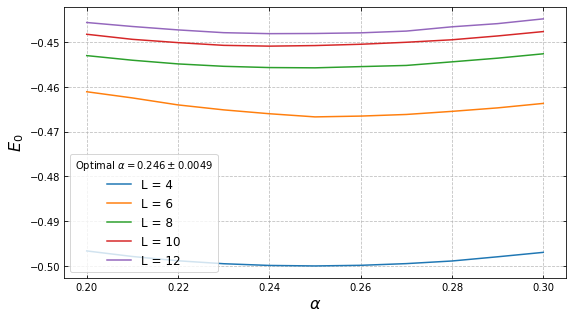

In [206]:
################ Not a good idea to put exactly diagonalized eigen values as plot  but can be compared in the 
################  tabular form since all the exact values from Lanczos are near 0.50 something. 
plt.figure(figsize=(9,5))
#plt.plot(alpha2,E2)
plt.plot(alpha2,E4,label="L = 4")
plt.plot(alpha2,E6,label="L = 6")
plt.plot(alpha2,E8,label="L = 8")
plt.plot(alpha2,E10,label="L = 10")
plt.plot(alpha2,E12,label="L = 12")

min_alpha_list = []
for E in [E4,E6,E8,E10,E12]:
    min_alpha_list.append(alpha2[np.argmin(E)])
opt_alpha = np.mean(min_alpha_list)
opt_alpha_sd = np.std(min_alpha_list)

# aesthetics
plt.legend(title="Optimal $\\alpha = %.3f \\pm %.4f$"%(opt_alpha,opt_alpha_sd), loc='best',prop={'size': 12})
plt.tick_params(direction='in',bottom=True,top=True,left=True,right=True)
plt.grid(linestyle='--',alpha=0.8,which='both')


plt.xlim([0.195,0.305])
plt.xlabel("$\\alpha$",size=16)
plt.ylabel("$E_0$",size=16)
#plt.title("")
plt.show()

### Plotting ground state energies against $1/L^2$

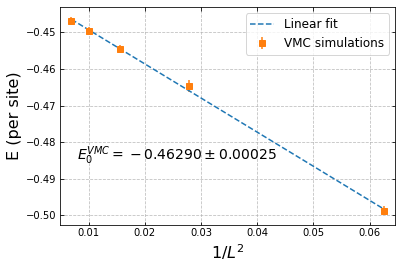

In [207]:
# Plot E0 vs 1/L^2
x = (1/np.array([4,6,8,10,12]))**2

E0_mean  = list(map(np.mean,[E4,E6,E8,E10,E12]))
#np.mean(E for E in [E4,E6,E8,E10,E12])
E0_std = list(map(np.std,[E4,E6,E8,E10,E12]))

# linear fit
m,c = np.polyfit(x,E0_mean,deg=1)
x_fit = np.linspace(min(x), max(x),20)
y_fit = m*x_fit+c
plt.plot(x_fit, y_fit,"--",label='Linear fit')


plt.errorbar(x, E0_mean, E0_std, linestyle='None',marker='s',label="VMC simulations" )  
plt.legend(loc='best',prop={'size': 12})
plt.tick_params(direction='in',bottom=True,top=True,left=True,right=True)
plt.grid(linestyle='--',alpha=0.8,which='both')
plt.text(0.008,-0.485,"$E_0^{VMC} = %.5f \\pm %.5f$"%(np.mean(E0_mean),np.std(E0_std)),size=14)

plt.xlim([min(x)-0.002,max(x)+0.002])
plt.xlabel("$1/L^2$",size=16)
plt.ylabel("E (per site)",size=16)
#plt.title("")
plt.show()

## Time Complexity for h=0

In [ ]:
time_list = []
for n in np.arange(2, 40, 2):
    start = time.time()
    E, F_m, alpha, xInit, t = main(n,100000,  0, 0.2, 0.32, alpha_step = 0.01)
    end = time.time()
    t = (end-start)/60
    print(n, t)
    time_list.append(t)

In [ ]:
def linear(x, a ,b):
    return a*x + b
def cuadratic(x, a ,b, c):
    return a*x**2 +b*x+c
import seaborn as sns; sns.set_theme(color_codes=True)

color=cm.rainbow(np.arange(0, 1, 0.15))
plt.figure(figsize=(10, 7))
nn_part = np.arange(2, 40, 2)
i =0
plt.loglog(nn_part, time_list, ".", color = color[i], markersize=15, label  ='CPU time')
#linear
popt_up, _   = curve_fit(cuadratic, nn_part, time_list)
plt.loglog(nn_part, popt_up[0] * np.array(nn_part)**2+ popt_up[1]* np.array(nn_part)+ popt_up[2],color = color[i], label = 'Cuadratic Fit(a = '+"{:.2E}".format(popt_up[0])+'; b = '+ "{:.2E}".format(popt_up[1])+'; c = '+ "{:.2E}".format(popt_up[2])+')')
print("R score="+"{:.2F}".format(r2_score( time_list, popt_up[0] * np.array(nn_part)**2+ popt_up[1]* np.array(nn_part)+ popt_up[2])))


plt.ylabel('Time', fontsize = 15)
plt.xlabel('N', fontsize = 15)
plt.tick_params(direction='in',bottom=True,top=True,left=True,right=True)
plt.legend(loc="best",prop={'size': 15})
plt.show()

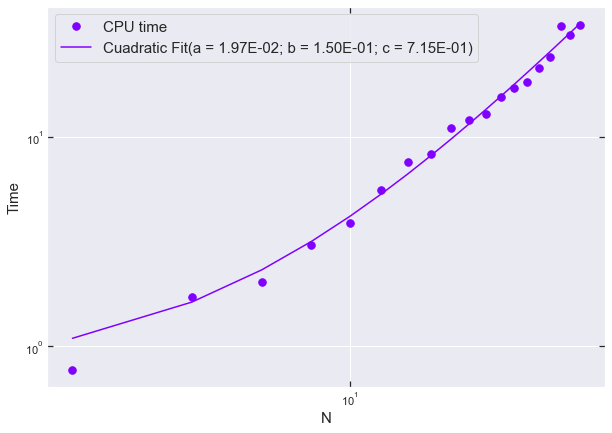

In [68]:
# Nope, never run import qutip in the first instant. 
import dill
#dill.dump_session("vmc.db")

In [ ]:
dill.load("vmc.db")